In [1]:
import pyfits
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.cosmology import WMAP9 as cosmo
import matplotlib
import math
from scipy import ndimage
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage import iterate_structure
from scipy.ndimage.filters import maximum_filter
import scipy.optimize as opt
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.io import fits
import math
import photutils
import statmorph
from skimage import measure
from bresenham import bresenham
from photutils import CircularAperture,aperture_photometry
import cv2
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp



print('compiled')

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


compiled


In [10]:
def gauss(x,a,x0,sigma,offset):
    return a*exp(-(x-x0)**2/(2*sigma**2))+offset
            
def fit_2_gaussian(data):
    """
    Fits 2D gaussians to surface brightness using the guesses from the low pass filter of the galaxy locations
    Basically, this is my own design of a rough precursor to Source Extractor
    """
    # Create x and y indices
    data=np.flipud(data)
    x = np.linspace(0, np.shape(data)[0]-1,np.shape(data)[0])
    y = np.linspace(0, np.shape(data)[1]-1, np.shape(data)[1])
    x, y = np.meshgrid(x, y)
    

    
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    #ax.hold(True)
    #im = ax.imshow(data, cmap=plt.cm.jet, origin='bottom')
    #I haven't figured out how to create contours without also creating a plot
    cs = ax.contour(x, y, data, 8, colors='w')
    plt.clf()
    
    p = cs.levels#collections[0].get_paths()[0]
    
    
    #Now, snatch the last level and use it to blur everything else out and find the center with a binary threshold
    ret,thresh = cv2.threshold(data,p[-1]/2,2000,cv2.THRESH_BINARY)

    M = cv2.moments(thresh)
    
    
 
    # calculate x,y coordinate of center
    
    cX = int(M["m10"] / M["m00"])
    
        
    cY = int(M["m01"] / M["m00"])
    
    
    
    return cX, np.shape(data)[0]-cY
    



def compare_centers(image, disp, x_kin, y_kin, z):
    """
    Compares the centeroid of the r-band image to that of the velocity dispersion 2D map,
    also to the kinematic center (x_kin,y_kin).
    It does this in terms of a physical distance in kpc, given the redshift of the galaxy.
    """

    
    
    #Apply a 10x10 kernal to the image to filter out noise (its basically a low pass filter)
    #to smooth things out
    kernel = np.ones((10,10))

    lp = ndimage.convolve(image.filled(fill_value=0), kernel)#was result
    
    
    c=fit_2_gaussian(lp)



    
    
    img_cen_x = c[0]
    img_cen_y = c[1]
    
    
    #Do this whole thing again but for the velocity dispersion map
    kernel = np.ones((10,10))

    lp = ndimage.convolve(disp.filled(fill_value=0), kernel)#was result

    c=fit_2_gaussian(lp)

    disp_cen_x = c[0]
    disp_cen_y = c[1]
    
    
    kpc_arcsec=(cosmo.kpc_proper_per_arcmin(z).value/60)
    spax_to_kpc = 0.5*kpc_arcsec
    
    
    
    
    return spax_to_kpc*np.sqrt((img_cen_x-disp_cen_x)**2+(img_cen_y-disp_cen_y)**2), spax_to_kpc*np.sqrt((img_cen_x-x_kin)**2+(img_cen_y-y_kin)**2)








    
    
    
def extract_GALFIT_parameters(vers,view, myr, im, run):
    """
    This retrives the GALFIT predictors 
    """
    output=str(vers)+'/GALFIT_folder/out_'+str(run)+'_'+str(view)+'_'+str(myr)+'.fits'
    try:
        out=pyfits.open(output)
    except FileNotFoundError:
        print('NO GALFIT FILEEEE')
        
        
        return 0, 0, 0

    

    try:
        try:
            attempt=float(out[2].header['1_MAG'][0:5])
            attempt_2=float(out[2].header['2_MAG'][0:5])
        except ValueError:
            return 0, 0, 0
        if float(out[2].header['1_MAG'][0:5]) < float(out[2].header['2_MAG'][0:5]):
        #this means the 1st one is brighter
            inc=float(out[2].header['1_AR'][0:5])
            r_e=float(out[2].header['1_RE'][0:5])
            PA_img=(float(out[2].header['1_PA'][:5]))
            
        else:
            try:
                inc=float(out[2].header['2_AR'][0:5])
                r_e=float(out[2].header['2_RE'][0:5])
                PA_img=(float(out[2].header['2_PA'][:5]))
            except:
                return 0, 0, 0
    except KeyError or ValueError:#if there is no #2
        try:
            
            inc=float(out[2].header['1_AR'][0:5])
            r_e=float(out[2].header['1_RE'][0:5])
            PA_img=(float(out[2].header['1_PA'][:5]))
        except ValueError:
            return 0, 0, 0
        
    return PA_img, inc, r_e


def map_to_coords(map_cube, size):
    """
    Converts coordinates to list form (in order to feed through kinemetry).
    """
    x_list=[]
    y_list=[]
    vel_list=[]
    vel_e_list=[]
    sig_list=[]
    sig_e_list=[]
    
    vel_dimension=map_cube[1].data
    vel_e_dimension=map_cube[2].data
    sig_dimension=map_cube[3].data
    sig_e_dimension=map_cube[4].data
    
    for i in range(size):
        for j in range(size):
            try:
                value = vel_dimension[i,j]
                if str(value) == '--':
                    continue
                vel_list.append(vel_dimension[i,j])
                x_list.append(i)
                y_list.append(j)
                vel_e_list.append(vel_e_dimension[i,j])
                sig_list.append(sig_dimension[i,j])
                sig_e_list.append(sig_e_dimension[i,j])
            except IndexError:
                continue
            
    
    
    return x_list, y_list, vel_list, vel_e_list, sig_list, sig_e_list



def input_kinemetry(degrade, adds, name, myr, view, x_list_after, y_list_after, vel_list_after, vel_e_list_after, sig_list_after, sig_e_list_after,  img_x, img_y, add_on, plot, size):
    """
    Creates an input file for kinemetry (.txt file) that has columns of x and y coords, velocity, velocity dispersion,
    and the errors on both of these values.
    """
    print(os.getcwd())
    file2=open('kinemetry_input_txt/kinemetry_input_'+str(adds)+'_'+str(name)+'_'+str(myr)+'_'+str(view)+'_'+str(degrade)+'.txt','w')
    file2.write('#'+'\t'+'XBIN'+'\t'+'YBIN'+'\t'+'VEL'+'\t'+'ER_VEL'+'\t'+'SIG'+'\t'+'ER_SIG'+'\n')
    
    #These are the coordinates of the kinematic center of the galaxy
    middle_x=img_x
    middle_y=img_y
    
    #for some reason, kinemetry wants each row indexed
    counter=1
    
    for i in range(len(x_list_after)):
        if np.isnan(vel_list_after[i]):#mask these values by not including them in the file
            #file2.write(str(counter)+'\t'+str((middle_x-x_list_after[len(x_list_after)-1-i]))+'\t'+str((middle_y-y_list_after[len(x_list_after)-1-i]))+'\t')
            #file2.write('--'+'\t'+'--'+'\t'+'--'+'\t'+'--'+'\n')
        
            continue
        if vel_e_list_after[i]==0.0:#these are also list indices to mask
            #file2.write(str(counter)+'\t'+str((middle_x-x_list_after[len(x_list_after)-1-i]))+'\t'+str((middle_y-y_list_after[len(x_list_after)-1-i]))+'\t')
            #file2.write('--'+'\t'+'--'+'\t'+'--'+'\t'+'--'+'\n')
        
            continue
        file2.write(str(counter)+'\t'+str((middle_x-x_list_after[len(x_list_after)-1-i]))+'\t'+str((middle_y-y_list_after[len(x_list_after)-1-i]))+'\t')
        file2.write(str(vel_list_after[i])+'\t'+str(vel_e_list_after[i])+'\t'+str(sig_list_after[i])+'\t'+str(sig_e_list_after[i])+'\n')
        counter +=1

    file2.close()
    print('wrote this file', )
    #optional, you can plot it to check
    if plot=='yes':
        file_check='kinemetry_input_txt/kinemetry_input_'+str(adds)+'_'+str(name)+'_'+str(myr)+'_'+str(view)+'_'+str(degrade)+'.txt'
        stel_vel=np.zeros((size,size))
    
        with open(file_check, 'r') as f:
            data = f.readlines()


            x_list=[]
            y_list=[]
            vel_list=[]
            

            for line in data:
                words = line.split()
                #print('words', words)

                if words[1]=='XBIN':
                    continue
                else:
                    x_list.append(float(words[1]))
                    y_list.append(float(words[2]))
                    vel_list.append(float(words[3]))
                    
                    stel_vel[int(float(words[1])-size/2),int(float(words[2])-size/2)] = float(words[3])
                    
        plt.clf()
        im0=plt.imshow(stel_vel, cmap='RdBu_r', vmin=-150, vmax=150)
        plt.scatter(np.shape(stel_vel)[0]/2, np.shape(stel_vel)[1]/2, color='red', marker='x')
        plt.axhline(y=np.shape(stel_vel)[0]/2, color='red')
        plt.axvline(x=np.shape(stel_vel)[0]/2, color='red')
    
        plt.colorbar(im0)
        plt.show()
        
def read_kin_maps(degrade, adds, img, name, myr, view, dia, PA_img, size_cont, add_on, observed_velocity, kincen):
    size=size_cont
    file_velcirc='kinemetry_solution/vcirc_model_'+str(adds)+'_'+str(name)+'_'+str(myr)+'_'+str(view)+'_'+str(degrade)+'.txt'
    
    stel_vel_model=np.zeros((size,size))
    stel_vel_model_tester=np.zeros((size,size))
    stel_vel=np.zeros((size,size))
    stel_sig_model=np.zeros((size,size))
    stel_vel_kin_model=np.zeros((size,size))

    try:
        with open(file_velcirc, 'r') as f:
            data = f.readlines()


            x_list_model=[]
            y_list_model=[]
            vel_circ_model=[]
            vel_kin_model=[]
            vel_in=[]
            vel_in_e=[]
            vel_sig_model=[]
            vel_kin_model=[]

            for line in data:
                words = line.split()
                #print('words', words)

                if words[4]=='*************************':
                    continue
                else:
                    x_list_model.append(float(words[0]))
                    y_list_model.append(float(words[1]))
                    vel_in.append(float(words[2]))
                    vel_in_e.append(float(words[3]))
                    vel_circ_model.append(float(words[4]))
                    vel_kin_model.append(float(words[5]))


                    stel_vel[int(float(words[0])-size/2),int(float(words[1])-size/2)] = float(words[2])
                    stel_vel_model[int(float(words[0])-size/2),int(float(words[1])-size/2)] = float(words[4])
                    stel_vel_kin_model[int(float(words[0])-size/2),int(float(words[1])-size/2)] = float(words[5])
                    #stel_vel_model_tester[int(float(words[1])-size/2),int(float(words[0])-size/2)] = float(words[4])
                
    except FileNotFoundError:
        
        return 0

    '''
    ~~~~~~~Sigs~~~~~~~
    '''
    stel_vel_model = ma.masked_where(stel_vel_model ==0, stel_vel_model)
    stel_vel_kin_model = ma.masked_where(stel_vel_kin_model ==0, stel_vel_kin_model)
    stel_vel = ma.masked_where(stel_vel ==0, stel_vel)
    #stel_sig_model=((ma.masked_where(stel_sig_model==0, stel_sig_model)))
    '''plt.clf()
    fig=plt.figure()
    ax0=fig.add_subplot(141)
    im0 = ax0.imshow(img, cmap='afmhot_r')
    plt.colorbar(im0)
    ax0.set_title('Imaging', size=10)
    
    ax1=fig.add_subplot(142)
    im1 = ax1.imshow((stel_vel), cmap='RdBu_r', vmin=-100, vmax=100)
    plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.colorbar(im1)
    ax1.axis('off')
    ax1.set_title(r'V$_{*}$', size=10)

    ax2=fig.add_subplot(143)
    im2 = ax2.imshow((stel_vel_model), cmap='RdBu_r', vmin=-100, vmax=100)
    plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    ax2.axis('off')
    plt.colorbar(im2)
    ax2.set_title(r'V$_{\mathrm{kinemetry}}$', size=10)
    
    
    
    ax3=fig.add_subplot(144)
    im3 = ax3.imshow(((stel_vel - stel_vel_model)/stel_vel_model), cmap='RdBu_r')#, vmin=-100, vmax=100)
    plt.xlim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.ylim([size/2-(dia-0.5)/2,size/2+(dia-0.5)/2])
    plt.colorbar(im3)
    plt.annotate(str(round(resids,1)),xy=(0.05,0.05), xycoords='axes fraction')
    ax3.axis('off')
    
    ax3.set_title(r'Velocity Residuals', size=10)
    
    #plt.colorbar(ax1)
    plt.savefig('../MaNGA_Papers/Paper_I/velocity_model_compare_'+str(add_on)+'_'+str(myr)+'_'+str(view)+'.pdf',bbox_inches='tight' )
    '''
    stel_vel_model=ma.masked_where(stel_vel_model > 1000, stel_vel_model)
    #stel_vel_model=ma.masked_where(stel_vel_model == 0, stel_vel_model)
    
    
    '''Now open the file with kinematic PA, v_asym, s_asym'''
    file_deets='kinemetry_solution/kinemetry_params_'+str(adds)+'_'+str(name)+'_'+str(myr)+'_'+str(view)+'_'+str(degrade)+'.txt'
    
    try:
        with open(file_deets, 'r') as f:
            data = f.readlines()
            words0 = data[0].split()
            PA_kin=float(words0[0])
            PA_kin_e=float(words0[1])
            v_asym=float(words0[2])
            s_asym=float(words0[3])
            K_asym=float(words0[4])
            
            words1 = data[1].split()
            
            inc_kin = float(words1[0])
    except FileNotFoundError:
        return 0
    
    '''try:
        with open(file_deets, 'r') as f:
            data = f.readlines()
            for line in data:
                words = line.split()

                PA_kin=float(words[0])
                PA_kin_e=float(words[1])
                v_asym=float(words[2])
                s_asym=float(words[3])
                K_asym=float(words[4])
    except FileNotFoundError:
        return 0'''
    
    x=np.linspace(0,size, 1000)
    ys_kin=[(j-size_cont/2)/math.tan(math.radians(PA_kin))+size_cont/2 for j in x]
    plt.clf()
    fig=plt.figure()
    ax0 = fig.add_subplot(131)
    im0 = ax0.imshow(observed_velocity, cmap='RdBu_r')#, vmin=-100, vmax=100)
    plt.colorbar(im0, fraction=0.05)
    ax0.scatter(np.shape(observed_velocity)[0]/2+kincen[1], np.shape(observed_velocity)[0]/2+kincen[0], color='black', marker='x')
    ax0.set_title('$V_{*}$')
    ax0.set_xlim([0,np.shape(observed_velocity)[0]])
    ax0.set_ylim([0,np.shape(observed_velocity)[1]])
    #ax0.axis('off')
    
    ax1 = fig.add_subplot(132)
    im1 = ax1.imshow(stel_vel_model, cmap='RdBu_r')#, vmin=-100, vmax=100)
    ax1.scatter(np.shape(observed_velocity)[0]/2+kincen[1], np.shape(observed_velocity)[0]/2+kincen[0], color='black', marker='x')
    
    ax1.set_xlim([0,np.shape(observed_velocity)[0]])
    ax1.set_ylim([0,np.shape(observed_velocity)[1]])
    
    ax1.plot(x,ys_kin, color='black')
    ax1.set_title('$V_{\mathrm{model}}$')
    plt.colorbar(im1, fraction=0.05)
    #plt.title(r'\texttt{kinemetry}')
    #ax1.axis('off')
    
    ax2 = fig.add_subplot(133)
    observed_mask = ma.masked_where(stel_vel_model==0, observed_velocity)
    resids=np.sum(abs(observed_mask - stel_vel_model))/stel_vel_model.count()#np.mean(abs((stel_vel - stel_vel_model)/stel_vel_model))
    #print('these are the resids', resids, 'n_spaxels', stel_vel_model.count())
    im2 = ax2.imshow((observed_mask - stel_vel_model),  cmap='RdBu_r', vmin=-50, vmax=50)
    ax2.scatter(np.shape(observed_velocity)[0]/2+kincen[1], np.shape(observed_velocity)[0]/2+kincen[0], color='black', marker='x')
    
    ax2.set_title('$V_{*} - V_{\mathrm{model}}$')
    plt.colorbar(im2, fraction=0.05)
    ax2.set_xlim([0,np.shape(observed_velocity)[0]])
    ax2.set_ylim([0,np.shape(observed_velocity)[1]])
    #ax2.axis('off')
    ax2.annotate('Residuals = '+str(round(resids,2)), xy=(0.05,0.85), xycoords='axes fraction')
    
    '''ax3 = fig.add_subplot(224)
    im3 = ax3.imshow(abs(observed_mask - stel_vel_model),  norm=matplotlib.colors.LogNorm(),cmap='magma')
    ax3.set_title('|$V_{*} - V_{\mathrm{model}}$|')
    plt.colorbar(im3, fraction=0.1)
    
    ax3.set_xlim([0,np.shape(observed_velocity)[0]])
    ax3.set_ylim([0,np.shape(observed_velocity)[1]])
    
    ax3.axis('off')'''

    plt.tight_layout()
    plt.savefig('figs/kinemetry_result_'+str(adds)+'_'+str(name)+'_'+str(myr)+'_'+str(view)+'.png')
    
    
    
    
    '''PA_kin is measured from the south CCW, so -115 is actually 115 degrees to the CW direction from south'''
    '''PA_imag is measured from the north CCW as well (argh)'''
    PA_kin_moved = PA_kin#was 180+PA_kin
    PA_img_moved = PA_img
    
    '''if abs(PA_img_moved-PA_kin_moved) > 90 and abs(PA_img_moved-PA_kin_moved) < 180:
        new_delta_PA = 180-abs(PA_img_moved-PA_kin_moved)
    else:
        new_delta_PA = abs(PA_img_moved-PA_kin_moved)
    if abs(PA_img_moved-PA_kin_moved) > 180:
        new_delta_PA = abs(PA_img_moved-PA_kin_moved)-180'''
    
    new_delta_PA = abs(PA_img_moved-PA_kin_moved)
    
    
    return new_delta_PA, v_asym, s_asym, K_asym, resids


    

def make_table(counter, image, merger, myr, view, dPA, v_a, s_a,  resids, i, j, lambdar, epsilon, A,  A_2, dpos, dpos2):
    #make_table(myr, view, out_kin[0], out_kin[1], out_kin[2], out_kin[3], out_kin[4])
    if dPA > 90:
        dPA = 180-dPA
    file1.write(str(counter)+'\t'+str(image)+'\t'+str(merger)+'\t'+str(round(myr,2))+'\t'+str(view)+'\t'+str(round(dPA,2))+'\t'+str(round(v_a,2))+
                    '\t'+str(round(s_a,2))+'\t'+str(round(resids,2))+'\t'+str(round(lambdar,2))+'\t'+str(round(epsilon,2))+'\t'+str(round(A,2))+'\t'+str(round(A_2,2))+'\t'+str(round(dpos,2))+'\t'+str(round(dpos2,2))+'\n')#was str(np.shape(vel_dist)[1]-1-j)
    
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]




def angular_momentum(velocity, dispersion, r_band, r_e):
    #lambda_r_e = f*r*|v|/f*r*(v**2+sig**2)^(1/2)
    #step 1 is to determine the effective radius in the r-band, which is from the full broadband image
    #so the effective radius is in spaxels here (I think?) so just mask if sqrt(x_dist**2+y_dist**2)
    #is greater than this amount
    middle = np.shape(velocity)[0]/2
    #print('middle', middle)
    num=[]
    denom=[]
    for x in range(np.shape(velocity)[0]):
        for y in range(np.shape(velocity)[1]):
            distance_from_center = np.sqrt((x - middle)**2 + (y-middle)**2)
            #print('distance', distance_from_center)
            if distance_from_center > r_e:
                continue
            else:
                num.append((r_band[x,y]*distance_from_center*abs(velocity[x,y])))
                denom.append((r_band[x,y]*distance_from_center*np.sqrt(velocity[x,y]**2+dispersion[x,y]**2)))
                #print('num', (r_band[x,y]*distance_from_center*abs(velocity[x,y])))
                #print('denom',(r_band[x,y]*distance_from_center*np.sqrt(velocity[x,y]**2+dispersion[x,y]**2)))
    #print('num', num)
    #print('denom', denom)
    
    #print(np.nansum(num))
    #print(np.nansum(denom))
    lambdar = np.nansum(num)/np.nansum(denom)   
    #print('lambdar', lambdar)
    #summed_lambda = np.sum(lambdar)
    return lambdar
def ndim_grid(start,stop):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.arange(start[i],stop[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

print('compiled')

compiled


In [11]:
def radon_python_mod(vel_field, n_p, n_theta, r_ap, factor, plot):
    """
    This section performs the radon transform, from Stark et al. 2018.
    
    It is a long calculation, because it first calculates the Absolute Radon Transform (R_AB) of the velocity field, 
    then it iterates for multiple choices of the kinematic center. It determines the kinematic center by minimizing
    the asymmetry, A, of the Radon profile calculated from R_AB using a centroiding method.
    
    If the kinematic center is on the edge of the search grid of spaxels, it throws a flag and the code will rerun
    this function after expanding the grid.
    
    """
    #It first converts the x and y coordinates into p and theta coordinates (circular)
    #p is rho, which is the distance of the point on the velocity field from the kinematic center
    p_list = np.linspace(-int(np.shape(vel_field)[0]/2)+5,int(np.shape(vel_field)[0]/2)-5, int(np.shape(vel_field)[0]/2)+1)#was 5
    p_list = np.linspace(-int(np.shape(vel_field)[0]/2)+5, int(np.shape(vel_field)[0]/2)-5,n_p)#was 20
   
    #theta is the angle from the negative y axis CCW to the point on the velocity map.
    theta_list = np.linspace(0, 180, n_theta)#was 10
    
    #It searches over a grid of coordinates around the photometric center to find the 'kinematic center',
    #so it creates a 3x3 grid (from -3 to 3 including 0) in 2D
    box_list=list(ndim_grid([-3, -3],[4,4]))
    #If the kinematic center is not found on the first iteration, it expands the dimensions of the grid
    #by a factor of 2 upon rerunning.
    box_list=[factor*x for x in box_list]
    
    
    
    #Here I create a X and Y meshgrid type list of these points, since this is a rough approximation of the 
    #full grid of points in order to later plot what is happening.
    X_list=[]
    Y_list=[]

    for j in range(len(box_list)):

        X_list.append(int(np.shape(vel_field)[0]/2+box_list[j][0]))#-10+box_list[b][0])
        Y_list.append(int(np.shape(vel_field)[1]/2+box_list[j][1]))#-10+box_list[b][1])
        
    #print('X_list', X_list)
    #print('Y_list', Y_list)
    
    #creates empty lists that will be populated with R_AB, and all other derived quantities from this for every 
    #rho, theta point.
    A_list=[]
    A_e_list=[]
    A_2_list=[]
    R_AB_list=[]
    theta_hat_list=[]
    theta_hat_e_list=[]
    
    
    #First run it for just the center one, index b=24 in order to normalize relative to the center
    #later on in the calculation of A.
    R_AB=[]
    b=24
    
    for i in range(len(p_list)):
        for j in range(len(theta_list)):
            #
            X = int(p_list[i]*math.cos(math.radians(theta_list[j]))+np.shape(vel_field)[0]/2-0.5+box_list[b][0])#-10+box_list[b][0])
            Y = int(p_list[i]*math.sin(math.radians(theta_list[j]))+np.shape(vel_field)[1]/2-0.5+box_list[b][1])#-10+box_list[b][1])
            

            '''We have an X and a Y and a theta (slope) so we should be able to get the intercept'''
            '''And then two more points on either end'''


            '''But we only want to calculate for things that are on the circle'''

            try:
                #if this point exists in the velocity field then you can continue
                test_value = vel_field[X,Y]
            except IndexError:
                R_AB.append(-1000)
                continue
            if np.isnan(vel_field[X,Y]):
                R_AB.append(-1000)
                STOP2
                continue

            if str(vel_field[X,Y]) == '--':
                R_AB.append(-1000)
                continue
            #calculate the slope of the line segment from the kinematic center (in this case the photometric center)
            #to the given point
            deltay = Y - np.shape(vel_field)[1]/2
            deltax = X - np.shape(vel_field)[0]/2
            #draw a line perpendicular to this; the radon transform will be calculated along this line
            slope_p = math.tan(math.radians(theta_list[j]+90))#-deltax/deltay
            #draw a line from the point to where it intersects the bottom left of the map, which is the new origin
            intercept = Y - slope_p*X



            if slope_p > 1000:
                #vertical, so calculate along one value of X for the entire length of y
                x_min = X
                x_max = X
                y_min = 0
                y_max = np.shape(vel_field)[0]
            else:
                x_min = 0
                x_max = np.shape(vel_field)[0]
                y_min = intercept
                y_max = intercept+slope_p*x_max

            #This neat line draws a line through a given set of coordinates
            bres_list = list(bresenham(int(x_min), int(y_min), int(x_max), int(y_max)))

            #to calculate the absolute Bounded Radon Transform, do this for all points that are within r_e/2 of the center
            #of the line:
            vel_append=[]
            for k in range(len(bres_list)):
                if bres_list[k][0] < 0 or bres_list[k][1] < 0:
                    continue
                if np.sqrt((bres_list[k][0]-X)**2+(bres_list[k][1]-Y)**2) > r_e/2:
                    continue
               
                try:
                    vel_append.append(vel_field[bres_list[k][1], bres_list[k][0]])
                    
                except IndexError:
                    continue

            #clean it up, no masked values in here!
            vel_append_clean=[]
            for k in range(len(vel_append)):
                if ma.is_masked(vel_append[k]):
                    continue
                else:
                    vel_append_clean.append(vel_append[k])


            #finally, create R_AB by summing all of these velocity differences
            if vel_append_clean:
                inside=vel_append_clean-np.mean(vel_append_clean)
                R_AB.append(np.sum(np.abs(inside)))
            else:
                R_AB.append(-1000)


    R_AB=ma.masked_where(np.isnan(R_AB), R_AB)
    R_AB = ma.masked_where(R_AB==-1000, R_AB)

    
    R_AB_array = np.reshape(R_AB, (len(p_list),len(theta_list)))


    #Now, extract the R_AB value at each rho value across all theta values.
    #This creates the Radon profile; the estimated value of theta hat that minimizes R_AB at each value of rho.
    #We minimize R_AB because we want the theta value at each rho that 

    #these are the estimated values of theta that are best fit for a value of rho
    theta_hat=[]
    theta_hat_e=[]

    for l in range(len(p_list)):

        marginalized = R_AB_array[l,:]
        marginalized = ma.masked_where(marginalized<1e-4, marginalized)
        count = len([i for i in marginalized if i > 1e-3])
        #count up how many elements are in the row of R_AB --> if it is less than 6, don't measure it
        #because it will cause an error when trying to fit a Gaussian, k = n+1
        if count < 6:
            theta_hat.append(0)
            theta_hat_e.append(0)
            continue

        if ma.is_masked(marginalized)==True:
            theta_hat.append(0)
            theta_hat_e.append(0)
            continue

        try:
            #initially, try to fit a negative gaussian to determine theta hat
            popt,pcov = curve_fit(gauss,theta_list,marginalized,p0=[-abs(np.min(marginalized)-np.max(marginalized)),theta_list[list(marginalized).index(np.min(marginalized))],20,np.mean(marginalized)])
            append_value = popt[1]
            
            
            
        except RuntimeError or OptimizeError: 
            theta_hat.append(0)
            theta_hat_e.append(0)

            continue
            
            

        #if the code fits a positive Gaussian, try a new guess for the correct theta hat, the second smallest value       
        if (popt[0]>0):
            try:
                popt,pcov = curve_fit(gauss,theta_list,marginalized,p0=[-abs(np.min(marginalized)-np.max(marginalized)),theta_list[list(marginalized).index(sorted(marginalized)[1])],20,np.mean(marginalized)])
                append_value = popt[1]
                if popt[0] > 0:
                    #if this doesn't work, quit and move on

                    theta_hat.append(0)
                    theta_hat_e.append(0)

                    continue

                
                

            except RuntimeError or OptimizeError :
                theta_hat.append(0)
                theta_hat_e.append(0)

                continue
        
        #sometimes, it is necessary to shift the xs because the peak is at 180, which is right at the edge
        if ((popt[1] - 3*np.sqrt(pcov[1][1])) < 0) or ((popt[1] + 3*np.sqrt(pcov[1][1])) > 180):
            theta_list_shifted = theta_list+find_nearest(theta_list,90)
            index_1 = list(theta_list).index(find_nearest(theta_list,90))
            new_marginalized = np.concatenate((marginalized[index_1:], marginalized[:index_1]))

            try:
                popt,pcov = curve_fit(gauss,theta_list_shifted,new_marginalized,p0=[-abs(np.min(new_marginalized)-np.max(new_marginalized)),theta_list_shifted[list(new_marginalized).index(np.min(new_marginalized))],20,np.mean(new_marginalized)])
                

                if popt[0] > 0:
                    theta_hat.append(0)
                    theta_hat_e.append(0)

                    continue
                    
                    
                if popt[1] > 180:
                    append_value = popt[1]-180
                else:
                    append_value = popt[1]

            except RuntimeError or OptimizeError :
                theta_hat.append(0)
                theta_hat_e.append(0)

                continue
            
        theta_hat.append(append_value)
        theta_hat_e.append(np.sqrt(pcov[1][1]))

    #now to calculate A, it is necessary to sum the values of theta hat at a mirror image of themselves
    #across p=0
    delta_theta_sum=[]
    delta_theta_sum_e=[]


    for l in range(int(len(p_list)/2)):
        if (theta_hat[0+l]==0) or (theta_hat[-1-l]==0) or (abs(theta_hat[0+l])>180) or (abs(theta_hat[-1-l]) > 180):

            delta_theta_sum.append(0)
            delta_theta_sum_e.append(0)
        else:
            if abs(theta_hat[0+l]-theta_hat[-1-l]) > 90:
                #because the maximum you can be apart is 90
                inside = 180 - abs(theta_hat[0+l]-theta_hat[-1-l])
            else:
                inside = abs(theta_hat[0+l]-theta_hat[-1-l])

            delta_theta_sum.append(inside)
            #I would also like to have an error estimate on this quantity:
            delta_theta_sum_e.append(np.sqrt((theta_hat_e[0+l])**2+
                                         (theta_hat_e[-1-l])**2))
    


    delta_theta_sum_masked=ma.masked_where(np.array(delta_theta_sum)==0, delta_theta_sum)

    

    OG_weight=ma.count(delta_theta_sum_masked)
    
    
    plt.clf()
    fig=plt.figure()
    ax0 = fig.add_subplot(111)
    if plot=='yes':
        
        im0 = ax0.imshow(vel_field, cmap='RdBu_r')
    
    
    #Okay now do this for all the other positions in box_list
    A_list=[]
    A_e_list=[]
    
    A_2_list=[]
    R_AB_list=[]
    theta_hat_list=[]
    theta_hat_e_list=[]

    
            
    A_list=[]
    A_e_list=[]
    A_2_list=[]
    R_AB_list=[]
    theta_hat_list=[]
    theta_hat_e_list=[]
    
    X_list_real=[]
    Y_list_real=[]
    

    for b in range(len(box_list)):
        R_AB=[]
        X_list_real.append(np.shape(vel_field)[0]/2-0.5+box_list[b][0])
        Y_list_real.append(np.shape(vel_field)[1]/2-0.5+box_list[b][1])
        for i in range(len(p_list)):
            for j in range(len(theta_list)):
                #
                X = int(p_list[i]*math.cos(math.radians(theta_list[j]))+np.shape(vel_field)[0]/2-0.5+box_list[b][0])#-10+box_list[b][0])
                Y = int(p_list[i]*math.sin(math.radians(theta_list[j]))+np.shape(vel_field)[1]/2-0.5+box_list[b][1])#-10+box_list[b][1])
                
                try:
                    #if this point exists in the velocity field then you can continue
                    test_value = vel_field[X,Y]
                except IndexError:
                    R_AB.append(-1000)
                    continue
                if np.isnan(vel_field[X,Y]):
                    R_AB.append(-1000)
                    STOP2
                    continue

                if str(vel_field[X,Y]) == '--':
                    R_AB.append(-1000)
                    continue
                #calculate the slope of the line segment from the kinematic center (in this case the photometric center)
                #to the given point
                deltay = Y - np.shape(vel_field)[1]/2
                deltax = X - np.shape(vel_field)[0]/2
                #draw a line perpendicular to this; the radon transform will be calculated along this line
                slope_p = math.tan(math.radians(theta_list[j]+90))#-deltax/deltay
                #draw a line from the point to where it intersects the bottom left of the map, which is the new origin
                intercept = Y - slope_p*X



                if slope_p > 1000:
                    #vertical, so calculate along one value of X for the entire length of y
                    x_min = X
                    x_max = X
                    y_min = 0
                    y_max = np.shape(vel_field)[0]
                else:
                    x_min = 0
                    x_max = np.shape(vel_field)[0]
                    y_min = intercept
                    y_max = intercept+slope_p*x_max

                #This neat line draws a line through a given set of coordinates
                bres_list = list(bresenham(int(x_min), int(y_min), int(x_max), int(y_max)))

                
                #to calculate the absolute Bounded Radon Transform, do this for all points that are within r_e/2 of the center
                #of the line:
                vel_append=[]
                for k in range(len(bres_list)):
                    if bres_list[k][0] < 0 or bres_list[k][1] < 0:
                        continue
                    if np.sqrt((bres_list[k][0]-X)**2+(bres_list[k][1]-Y)**2) > r_e/2:
                        continue

                    try:

                        vel_append.append(vel_field[bres_list[k][1], bres_list[k][0]])
                        #vel_new[bres_list[j][1], bres_list[j][0]] = vel_field[bres_list[j][1], bres_list[j][0]]
                    except IndexError:
                        continue

                #clean it up, no masked values in here!
                vel_append_clean=[]
                for k in range(len(vel_append)):
                    if ma.is_masked(vel_append[k]):
                        continue
                    else:
                        vel_append_clean.append(vel_append[k])


                #finally, create R_AB by summing all of these velocity differences
                if vel_append_clean:
                    inside=vel_append_clean-np.mean(vel_append_clean)
                    R_AB.append(np.sum(np.abs(inside)))
                else:
                    R_AB.append(-1000)


        R_AB=ma.masked_where(np.isnan(R_AB), R_AB)
        R_AB = ma.masked_where(R_AB==-1000, R_AB)


        R_AB_array = np.reshape(R_AB, (len(p_list),len(theta_list)))


        #Now, extract the R_AB value at each rho value across all theta values.
        #This creates the Radon profile; the estimated value of theta hat that minimizes R_AB at each value of rho.
        #We minimize R_AB because we want the theta value at each rho that 

        #these are the estimated values of theta that are best fit for a value of rho
        theta_hat=[]
        theta_hat_e=[]

        for l in range(len(p_list)):

            marginalized = R_AB_array[l,:]
            marginalized = ma.masked_where(marginalized<1e-4, marginalized)
            count = len([i for i in marginalized if i > 1e-3])
            #count up how many elements are in the row of R_AB --> if it is less than 6, don't measure it
            #because it will cause an error when trying to fit a Gaussian, k = n+1
            if count < 6:
                theta_hat.append(0)
                theta_hat_e.append(0)
                continue

            if ma.is_masked(marginalized)==True:
                theta_hat.append(0)
                theta_hat_e.append(0)
                continue

            try:
                popt,pcov = curve_fit(gauss,theta_list,marginalized,p0=[-abs(np.min(marginalized)-np.max(marginalized)),theta_list[list(marginalized).index(np.min(marginalized))],20,np.mean(marginalized)])
                append_value = popt[1]

                

            #sometimes, it is necessary to shift the xs because the peak is at 180, which is right at the cutoff
            except RuntimeError or OptimizeError: 
                theta_hat.append(0)
                theta_hat_e.append(0)

                continue
                


                    
            if (popt[0]>0):
                try:
                    popt,pcov = curve_fit(gauss,theta_list,marginalized,p0=[-abs(np.min(marginalized)-np.max(marginalized)),theta_list[list(marginalized).index(sorted(marginalized)[1])],20,np.mean(marginalized)])
                    append_value = popt[1]
                    if popt[0] > 0:


                        theta_hat.append(0)
                        theta_hat_e.append(0)

                        continue


                except RuntimeError or OptimizeError :
                    theta_hat.append(0)
                    theta_hat_e.append(0)

                    continue
            if ((popt[1] - 3*np.sqrt(pcov[1][1])) < 0) or ((popt[1] + 3*np.sqrt(pcov[1][1])) > 180):
                theta_list_shifted = theta_list+find_nearest(theta_list,90)
                index_1 = list(theta_list).index(find_nearest(theta_list,90))
                new_marginalized = np.concatenate((marginalized[index_1:], marginalized[:index_1]))

                try:
                    popt,pcov = curve_fit(gauss,theta_list_shifted,new_marginalized,p0=[-abs(np.min(new_marginalized)-np.max(new_marginalized)),theta_list_shifted[list(new_marginalized).index(np.min(new_marginalized))],20,np.mean(new_marginalized)])
                    
                    if popt[0] > 0:
                        theta_hat.append(0)
                        theta_hat_e.append(0)

                        continue

                    
                    if popt[1] > 180:
                        append_value = popt[1]-180
                    else:
                        append_value = popt[1]

                except RuntimeError or OptimizeError :
                    theta_hat.append(0)
                    theta_hat_e.append(0)

                    continue

            theta_hat.append(append_value)
            theta_hat_e.append(np.sqrt(pcov[1][1]))



 

        delta_theta_sum=[]
        delta_theta_sum_e=[]
        
        
        for l in range(int(len(p_list)/2)):
            if (theta_hat[0+l]==0) or (theta_hat[-1-l]==0) or (abs(theta_hat[0+l])>180) or (abs(theta_hat[-1-l]) > 180):
                
                delta_theta_sum.append(0)
                delta_theta_sum_e.append(0)
            else:
                
                
                if abs(theta_hat[0+l]-theta_hat[-1-l]) > 90:
                    #because the maximum you can be apart is 90
                    inside = 180 - abs(theta_hat[0+l]-theta_hat[-1-l])
                else:
                    inside = abs(theta_hat[0+l]-theta_hat[-1-l])
                
                delta_theta_sum.append(inside)
                delta_theta_sum_e.append(np.sqrt((theta_hat_e[0+l])**2+
                                             (theta_hat_e[-1-l])**2))
        
            
            
            
        theta_hat_mask = ma.masked_where(theta_hat==0, theta_hat)
        theta_hat_mask = ma.masked_where(abs(theta_hat_mask) >180, theta_hat_mask)
        
        theta_hat_list.append(theta_hat_mask)
        theta_hat_e_list.append(theta_hat_e)
        
        delta_theta_sum_masked=ma.masked_where(np.array(delta_theta_sum)==0, delta_theta_sum)

        #A is weighted by the A value of the center of the map
        A = ((ma.sum(delta_theta_sum)/(ma.count(delta_theta_sum_masked)**2)))*OG_weight
       
        A_percent_e = []
        for l in range(len(delta_theta_sum_e)):
            if delta_theta_sum[l] != 0 :
                A_percent_e.append((delta_theta_sum_e[l])**2)
        A_abs_error = np.sqrt(np.sum(A_percent_e))#so this is on the numerator of the A error only
        A_error = (A_abs_error/ma.sum(delta_theta_sum))*A
       
        
        
        A_list.append(A)
        
        
        A_e_list.append(A_error)

        #Also calculates the other types of asymmetry:
        #A_2
        delta_theta_sum=ma.masked_where(np.array(delta_theta_sum)==0, delta_theta_sum)
        delta_theta_sum_e=ma.masked_where(np.array(delta_theta_sum_e)==0, delta_theta_sum_e)
        
        
        A_2 = ma.sum(delta_theta_sum/delta_theta_sum_e)
        
        
        
        A_2_list.append(A_2)
        
        R_AB_list.append(R_AB_array)
        
    
      
    
    
    A_list = np.array(A_list)
    A_list = ma.masked_where(np.isnan(A_list), A_list)
    
    A_list_array = np.reshape(np.array(A_list), (7,7))
    A_e_list_array = np.reshape(np.array(A_e_list), (7,7))

    
    first_number = 33-3*factor#33-3*factor = 27 if factor = 2
    x = factor*np.linspace(0, np.shape(A_list_array)[0]-1,np.shape(A_list_array)[0])+first_number
    #y = (factor*6-factor*np.linspace(0, np.shape(A_list_array)[1]-1, np.shape(A_list_array)[1]))+first_number
    y = (factor*np.linspace(0, np.shape(A_list_array)[1]-1, np.shape(A_list_array)[1]))+first_number
    
    if min(X_list_real) != min(x):
        #this is improper scaling
        print('x and y', x, y)
    
        print('this is what it should match X_list', X_list_real, Y_list_real)
    
        STOP
    
    
    x, y = np.meshgrid(x, y)
    
    
    
    
    
    cs = ax0.contour(x,y, A_list_array, 5, colors='orange')#was 5
    p = cs.levels#collections[0].get_paths()[0]
    
    if plot=='yes':
        im1 = ax0.scatter(np.flip(Y_list_real, axis=0),X_list_real,c=A_list, s=30, zorder=100)

        plt.colorbar(im0)
    
    #Now, snatch the last level and use it to blur everything else out and find the center
    #now fill with zeros and do your best to turn into a binary bitmask'''
    ret,thresh = cv2.threshold(A_list_array,p[-1]/2,100,cv2.THRESH_BINARY_INV)
    M = cv2.moments(thresh)



    # calculate x,y coordinate of center
    try:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    except ZeroDivisionError:
        ret,thresh = cv2.threshold(A_list_array,p[3],100,cv2.THRESH_BINARY_INV)
        M = cv2.moments(thresh)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    
    
    
    
    
    #transform to flip in the x coordinate around the center coordinate, which changes based on the factor
    cX_flip = 6-cX
    
    x_match = cX_flip+33-3*factor
    y_match = (cY)+33-3*factor
    
    
    
    
    
    if plot=='yes':
        

        print('this is the cX and cY', x_match, y_match)


        plt.scatter( x_match, y_match, marker='x', color='red', zorder=105)
        plt.axhline(y=np.shape(vel_field)[0]/2, color='red')
        plt.axvline(x=np.shape(vel_field)[0]/2, color='red')

        plt.show()
    
    
    
    
        plt.clf()
        plt.imshow(thresh)
        plt.scatter(cX,cY, marker='x', color='red')

        x = np.linspace(0, np.shape(A_list_array)[0]-1,np.shape(A_list_array)[0])
        y = (np.linspace(0, np.shape(A_list_array)[1]-1, np.shape(A_list_array)[1]))
        x, y = np.meshgrid(x,y)

        plt.contour(x,y, A_list_array, 5, colors='orange')#was 5
        plt.xlim([6,0])

        plt.show()
    
    
    
    
    
    '''now find the min index of this'''
    for ii in range(len(X_list)):
        if X_list[ii]==find_nearest(np.array(X_list),x_match) and Y_list[ii]==find_nearest(np.array(np.flip(Y_list, axis=0)),y_match):
            min_index = ii
        
    
    
    
    if factor ==1:
        if abs(box_list[min_index][0])>2 or abs(box_list[min_index][1])>2:
            #then we are on the edge
            expand=1
        else:
            expand=0
    else:
        if abs(box_list[min_index][0])>5 or abs(box_list[min_index][1])>5:
            min_index=24
        expand=0
        
    
    
    
    
   
    return box_list[min_index],R_AB_list[min_index], A_list[min_index],  A_2_list[min_index],p_list, theta_list, theta_hat_list[min_index], theta_hat_e_list[min_index], expand
print('compiled')

compiled


In [12]:
print('done')

done


In [ ]:
import os
print(os.getcwd())

os.chdir(os.path.expanduser('/Users/beckynevin/CfA_Code/Kinematics_SUNRISE/'))

import seaborn as sns
sns.set_style("dark")


view_list=[0,1,2,3,4,5,6]#1



myr_list=[170,180,185,190,205,210]
myr_list=[5,10,30,50,100,200]

myr_list=[20,40,70,80,100,120,140,150,170,180,190,210,220,230,235,237,
     240,242,245,247,250,252,255,257,262,265,270,275,280,285,
     287,288,289,290,295,300,305]

myr_list=[235,237,
     240,242,245,247,250,252,255,257,262,265,270,275,280,285,
     287,288,289,290,295,300,305]



myr_list=[220, 225, 230, 240, 250, 260,265,275,285, 295,305,311, 315,320,
     5,10,20,30,40,60,80,100,120,140,160]

#myr_list=[185]
#myr_list=[200,205,210]

#myr_list=[5,10,20,30,40,50,60,100,200]
#myr_list=[205,210]









myr_list=[5,10,20,30,40,50,60,100,200]

myr_list=[5,40,60,100,200,300,400,410,420,
     600,640,700,800,840,900,940,980,1000,1020,1040,1060,1080,1100,1140,
     1145,1150,1155,1160,1165,1168]

merger=1

#
#myr_list=[   5,30,60,90,100,120,150,180,200]


'''myr_list=[5,40,60,100,200,300,400,410,420,
     600,640,700,800,840,900,940,980,1000,1020,1040,1060,1080,1100,1140,
     1145,1150,1155,1160,1165,1168]'''

myr_list=[20,40,70,80,100,120,140,150,170,180,190,210,220,230,235,237,
     240,242,245,247,250,252,255,257,262,265,270,275,280,285,
     287,288,289,290,295,300,305]

#myr_list=[245,247,250,252,255,257,262,265,270,275,280,285,
#     287,288,289,290,295,300,305]

#myr_list=[5,20,60,90,120,150,180,210,240,270,300,320,340,360,380,400,420,440,460,480,500]
#myr_list=[185]

myr_list=[ 5,10,20,30,40,60,80,100,120,140,160,220, 225, 230, 240, 250, 260,265,275,285, 295,305,311, 315,320]
#myr_list=[170,180,185,190,205,210]

myr_list=[5,10,30,50,200]

#myr_list=[   5,10,20,30,40,50,60,100,200]
view_list=[0,1,2,3,4,5,6]







myr_list=[170,180,185, 190, 195, 205, 210, 220, 225, 230, 240, 250, 260,265,275,285, 295,305,311, 315,320,    5,10,20,30,40,60,80,100,120,140,160]
#myr_list=[60,80,100,120,140,160]
#myr_list=[240]
#view_list=[0,1,2,3,4,5,6]
#view_list=[5]

#myr_list=[225, 295, 315]


#myr_list=[5, 10, 30, 50, 200]
#myr_list=[5,10,20,30,40,50,60,100,200]
version='images'
adds='SCATTER_emline'#stellar_kinematics_NONSCATTER_kin_correct_noi

run_fix='fg3_m12'
run='fg3_m12'
degrade='degraded'

file1=open('LDA_input_tables/LDA_kin_'+str(adds)+'_'+str(version)+'_'+str(run_fix)+'_'+str(degrade)+'.txt','w')


plt.clf()
counter=0
z=0.03

for i in range(len(myr_list)):
    myr=myr_list[i]
    v_offsets=[]
    for j in range(len(view_list)):
        im=0
        view=view_list[j]
        print('myr, view', myr, view)
        
        
        
        if run=='fg3_m10':
            if myr > 420:
                im = pyfits.open('images/q0.1_fg0.3_BT0.2_allrx10_sunruns/hires_kin_late/broadband_'+str(myr)+'.fits')
            else:
                if myr < 10:
                    im = pyfits.open('images/q0.1_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_00'+str(myr)+'.fits')
                else:
                    if myr < 100:
                        im = pyfits.open('images/q0.1_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_0'+str(myr)+'.fits')
                    else:
                        im = pyfits.open('images/q0.1_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_'+str(myr)+'.fits')
        
        
        if run=='fg3_m13':
            if myr > 140:
                im = pyfits.open('images/q0.333_fg0.3_allrx10_sunruns/hires_kin_late/broadband_'+str(myr)+'.fits')
            else:
                if myr < 10:
                    im = pyfits.open('images/q0.333_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_00'+str(myr)+'.fits')
                else:
                    if myr < 100:
                        im = pyfits.open('images/q0.333_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_0'+str(myr)+'.fits')
                    else:
                        im = pyfits.open('images/q0.333_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_'+str(myr)+'.fits')
        
        if run=='fg3_m12_iso0.5':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            im = pyfits.open('images/isolated_galaxies/m0.5_fg0.3/broadband_'+prefix+str(myr)+'.fits')
            
        
        if run=='fg3_m12_iso1':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            im = pyfits.open('images/isolated_galaxies/m1_fg0.3/broadband_'+prefix+str(myr)+'.fits')
            
        if run=='fg3_m12':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            if myr < 170:
                im = pyfits.open(str(version)+'/q0.5_fg0.3_allrx10_sunruns/hires_kin_early_cen1/broadband_'+prefix+str(myr)+'.fits')
            else:
                im = pyfits.open(str(version)+'/q0.5_fg0.3_allrx10_sunruns/hires_kin/broadband_'+prefix+str(myr)+'.fits')
        if run=='fg3_m12_agnx0':
            im = pyfits.open('images/q0.5_fg0.3_allrx10_sunruns/agnx0/broadband_'+str(myr)+'.fits')
        
        if run=='fg3_m15_iso1':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            im = pyfits.open('images/isolated_galaxies/m1_fg0.3_BT0.2_allrx10_isolated_sunruns/broadband_'+prefix+str(myr)+'.fits')
        
        if run=='fg3_m15':
            if myr > 300:
                im = pyfits.open('images/q0.2_fg0.3_BT0.2_allrx10_sunruns/hires_kin_late/broadband_'+str(myr)+'.fits')
            else:
                if myr < 10:
                    im = pyfits.open('images/q0.2_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_00'+str(myr)+'.fits')
                else:
                    if myr < 100:
                        im = pyfits.open('images/q0.2_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_0'+str(myr)+'.fits')
                    else:
                        im = pyfits.open('images/q0.2_fg0.3_BT0.2_allrx10_sunruns/hires_kin_early_cen1/broadband_'+str(myr)+'.fits')
        if run=='fg1_m13':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            if myr > 140:
                
                if myr <360:
                    im = pyfits.open('images/q0.333_fg0.1_allrx10_sunruns/hires_kin_late/broadband_sdss_z0.03_'+prefix+str(myr)+'.fits')
                else:
                    im = pyfits.open('images/q0.333_fg0.1_allrx10_sunruns/hires_kin_late/broadband_'+prefix+str(myr)+'.fits')
            
            else:
                im = pyfits.open('images/q0.333_fg0.1_allrx10_sunruns/hires_kin_early_cen1/broadband_'+prefix+str(myr)+'.fits')
            
        if run=='fg1_m13_iso1':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            im = pyfits.open('images/isolated_galaxies/m1_fg0.1/broadband_'+prefix+str(myr)+'.fits')
        if run=='fg1_m13_iso0.333':
            if myr < 10:
                prefix='00'
            else:
                if myr < 100:
                    prefix='0'
                else:
                    prefix=''
            im = pyfits.open('images/isolated_galaxies/m0.333_fg0.1/broadband_'+prefix+str(myr)+'.fits')
            
        
        try:
            
            kin_cube=pyfits.open('kinematic_maps/stellar_kinematics_'+str(adds)+'_'+str(run_fix)+'_'+str(myr)+'_'+str(view)+'_'+str(degrade)+'.fits')
            #kin_cube=pyfits.open('stellar_kinematic_maps_sunrise/stellar_kinematics_NONSCATTER_'+str(myr)+'_'+str(view)+'.fits')
        
        except:# FileNotFoundError or OSError:
            print('STELLAR velocity map not there yet', os.getcwd(),'kinematic_maps/stellar_kinematics_'+str(adds)+'_'+str(run_fix)+'_'+str(myr)+'_'+str(view)+'_'+str(degrade)+'.fits')
            continue
        
        # First check to see if you actually have already written the GALFIT 
        try:
            file2=open('kinemetry_input_txt/kinemetry_input_'+str(adds)+'_'+str(run)+'_'+str(myr)+'_'+str(view)+'_'+str(degrade)+'.txt','r')
            try:
                file2=open('kinemetry_solution/vcirc_model_'+str(adds)+'_'+str(run)+'_'+str(myr)+'_'+str(view)+'_'+str(degrade)+'.txt', 'r')
            except:
                # If the kinemetry input file has been written but there's no kinemetry output
                print('Kinemetry input exists, no output yet, continuing')
                continue
        except:
            print('Does not yet exist proceeding to make it ', 'kinemetry_input_txt/kinemetry_input_'+str(adds)+'_'+str(run)+'_'+str(myr)+'_'+str(view)+'_'+str(degrade)+'.txt')
        dia = np.where(kin_cube[1].data != 0.0)
        dia_pix = (dia[1].max()-dia[1].min())#this is the number of pixels
        dia = dia_pix*0.5#because 0.5" per spaxel
        
        
        vel = ma.masked_where(kin_cube[1].data==0, kin_cube[1].data)
        vel_e = ma.masked_where(kin_cube[2].data==0, kin_cube[2].data)
        sig = ma.masked_where(kin_cube[3].data==0, kin_cube[3].data)
        sig_e = ma.masked_where(kin_cube[4].data==0, kin_cube[4].data)
        r_band = kin_cube[5].data
        r_band = ma.masked_where(r_band>1e10, r_band)
        
        vel = ma.masked_where(abs(vel)>1000, vel)
        vel_e = ma.masked_where(abs(vel)>1000, vel_e)
        
        
        #print(kin_cube[0].header)
        
        '''plt.clf()
        fig=plt.figure()
        ax0 = fig.add_subplot(231)
        im0 = ax0.imshow(vel, cmap='RdBu_r')
        plt.colorbar(im0)
        
        ax1 = fig.add_subplot(232)
        im1 = ax1.imshow(sig, cmap='Greens')
        plt.colorbar(im1)
        
        ax2 = fig.add_subplot(233)
        im2 = ax2.imshow(r_band,norm=matplotlib.colors.LogNorm(), cmap='afmhot')
        plt.colorbar(im2)
        
        ax3 = fig.add_subplot(234)
        im3 = ax3.imshow(vel_e, cmap='Reds')
        plt.colorbar(im3)
        
        ax4 = fig.add_subplot(235)
        im4 = ax4.imshow(sig_e, cmap='Reds')
        plt.colorbar(im4)
        
        plt.show()'''
        
        
        
        img_params=extract_GALFIT_parameters(version,view, myr, im, run)
        #return PA_img, size_a, arcs_totes, inc, pixelscale, r_e
        if img_params[0]==0:
            #this means the GALFIT file doesn't exist
            continue
        
        
        
        try:
            #I have found the PA from GALFIT to be better than the PA from statmorph 
            #which is commented out below
            PA_imag=img_params[0]
        except TypeError:
            continue
        
        
        epsilon = 1-img_params[1]
        r_e = img_params[2]
        
        #print('deltapos', deltapos)
        #continue
        
        #epsilon = float(kin_cube[0].header['ellip']), again the epsilon from GALFIT is better
        #r_e = float(kin_cube[0].header['REFF'])
        #PA_img = float(kin_cube[0].header['PA_img']), again, the PA from GALFIT seems to be better
        
        '''axial ratio (q) = b/a = semi-minor/semi-major
        ellipticity (ε) = 1 – q'''
        
        
        
        #from the r-band image you need to run statmorph and get both the ellipticity and the r-band effective radius
        #we already measured this from the r-band image in the kinematic program so I'd like to extract those two 
        #parameters from the header of the stellar_kinematics file
        
        
        
        size=np.shape(vel)[0]
        coords=map_to_coords(kin_cube, size)
        
        rad = radon_python_mod(vel, 30, 30, r_e, 1, 'no')#was 30,30
        if rad[8]==1:#this means we gotta expand the grid
            rad = radon_python_mod(vel, 30, 30, r_e, 2, 'no')
        
        
        
        #input_kinemetry(degrade,adds,run_fix, myr, view, coords[0], coords[1], coords[2], coords[3], coords[4], coords[5] , size/2-rad[0][1], size/2-rad[0][0], adds, 'yes', size)
        #print('output a file')
        
        #continue
        
        
        deltapos = compare_centers(r_band, sig, size/2-rad[0][0], size/2-rad[0][1], z)
        
        
        ang_mom = angular_momentum(vel, sig, r_band, r_e)
        
        
        myr_actual = im['SFRHIST'].header['SNAPTIME']/10**9
        
        
        
        

        out_kin=read_kin_maps(degrade,adds,r_band, run_fix, myr, view, dia, PA_imag, size, adds, vel, rad[0])
        
        if out_kin==0:
            continue
        
        if counter==0:
            file1.write('Counter'+'\t'+'Image'+'\t'+'class label'+'\t'+'Myr'+'\t'+'Viewpoint'+'\t'+'Delta PA'+'\t'+'v_asym'+'\t'+'s_asym'+'\t'+'resids'+'\t'+'lambda_r'+'\t'+'epsilon'+'\t'+'A'+'\t'+'A_2'+'\t'+'deltapos'+'\t'+'deltapos2'+'\n')#+'i'+'\t'+'fiber'+'\n')#was str(np.shape(vel_dist)[1]-1-j)
        try:
            #print('writing table')
            make_table(counter,run, merger, myr_actual, view, out_kin[0], out_kin[1], out_kin[2], out_kin[4],i, j, ang_mom, epsilon, rad[2],  rad[3], deltapos[0], deltapos[1])#, inclination, fiber[0])
        except TypeError:
            continue
        counter+=1
        
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        
        continue
        
        
        
        
        
        
        
        
        
        
        
file1.close()
print('finished')

import os
os.system('say "Code is Finished"')

/Users/beckynevin/CfA_Code/Kinematics_SUNRISE
myr, view 170 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
myr, view 170 1


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: invalid value encountered in sqrt
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:241: RuntimeWarning: invalid value encountered in sqrt
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:455: RuntimeWarning: invalid value encountered in sqrt
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:482: RuntimeWarning: invalid value encountered in sqrt
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:71: UserWarning: Warning: converting a masked element to nan.
  a = np.array(a, subok=True, copy=True)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
myr, view 170 2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
myr, view 170 3
Does not yet exist proceeding to make it  kinemetry_input_txt/kinemetry_input_SCATTER_emline_fg3_m12_170_3_degraded.txt
NO GALFIT FILEEEE
myr, view 170 4
STELLAR velocity map not there yet /Users/beckynevin/CfA_Code/Kinematics_SUNRISE kinematic_maps/stellar_kinematics_SCATTER_emline_fg3_m12_170_4_degraded.fits
myr, view 170 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
myr, view 170 6
STELLAR velocity map not there yet /Users/beckynevin/CfA_Code/Kinematics_SUNRISE kinematic_maps/stellar_kinematics_SCATTER_emline_fg3_m12_170_6_degraded.fits
myr, view 180 0


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:389: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
myr, view 180 1


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
myr, view 180 2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
myr, view 180 3


In [ ]:
import os
os.system('say "Code is Finished"')

In [11]:
file1.close()

In [ ]:
print('stopping?')

Myr = 195


<Figure size 432x288 with 0 Axes>

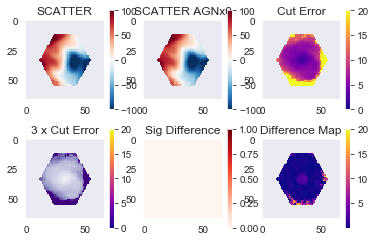

<Figure size 432x288 with 0 Axes>

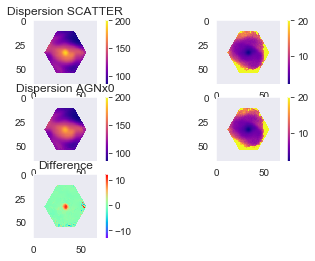

Myr = 195


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

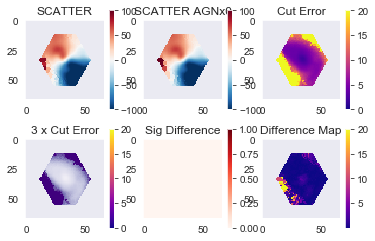

<Figure size 432x288 with 0 Axes>

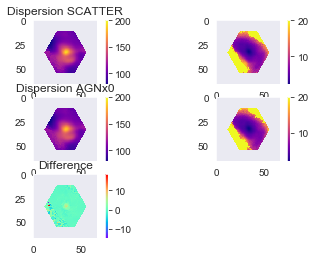

Myr = 195


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

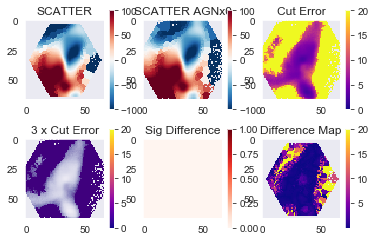

<Figure size 432x288 with 0 Axes>

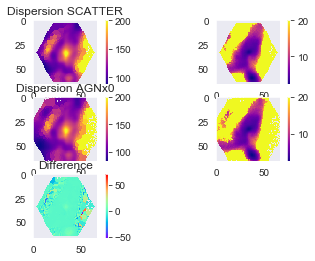

Myr = 195


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

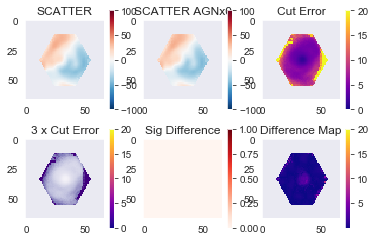

<Figure size 432x288 with 0 Axes>

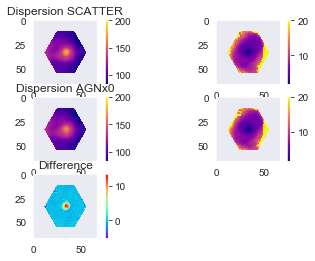

Myr = 195


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

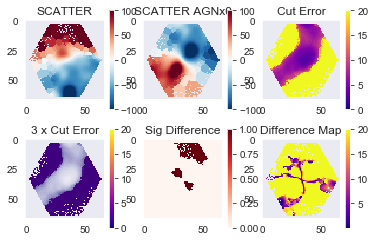

<Figure size 432x288 with 0 Axes>

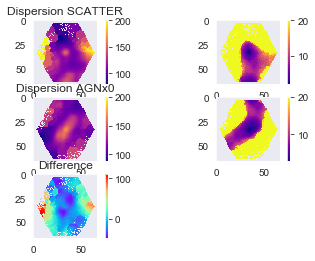

Myr = 205


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

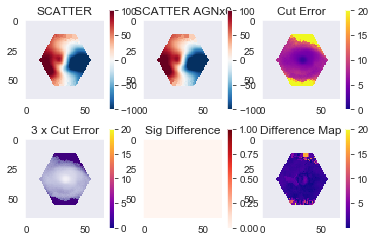

<Figure size 432x288 with 0 Axes>

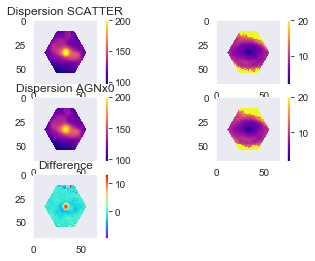

Myr = 205


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

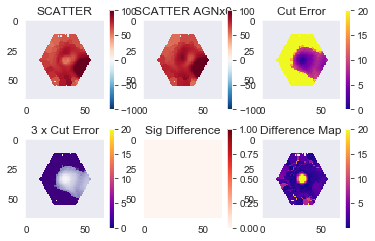

<Figure size 432x288 with 0 Axes>

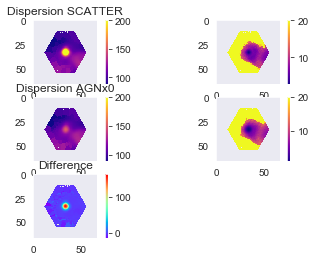

Myr = 205


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

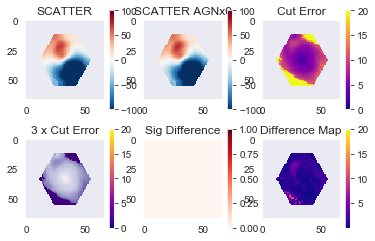

<Figure size 432x288 with 0 Axes>

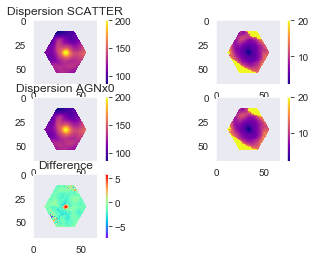

Myr = 205


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

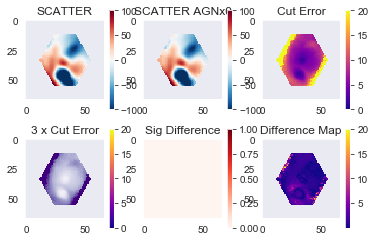

<Figure size 432x288 with 0 Axes>

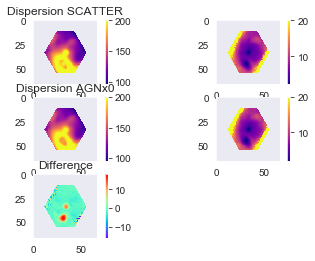

Myr = 205


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

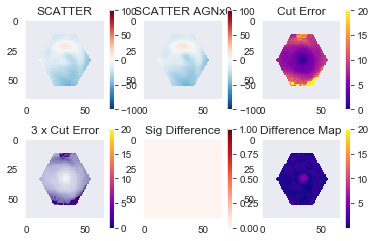

<Figure size 432x288 with 0 Axes>

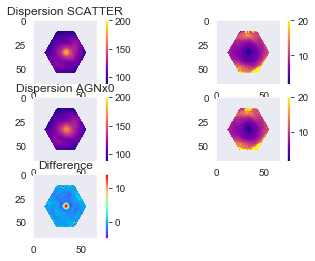

Myr = 205


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

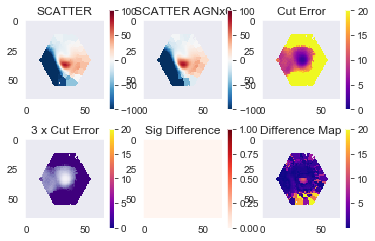

<Figure size 432x288 with 0 Axes>

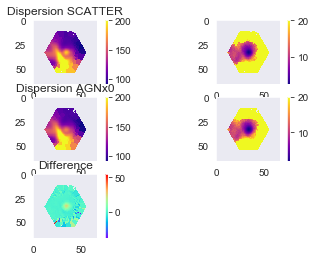

Myr = 205


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

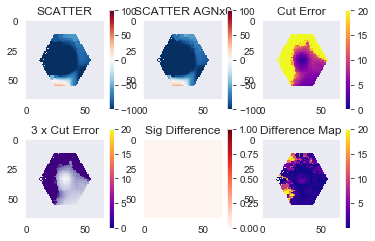

<Figure size 432x288 with 0 Axes>

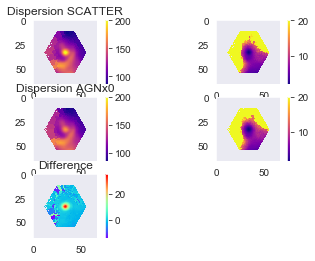

Myr = 210
Myr = 210
Myr = 210
Myr = 210
Myr = 210
Myr = 210
Myr = 210


<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

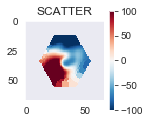

In [173]:
'''
Gotta directly compare
'''
view_list=[0,1,2,3,4,5,6]
myr_list=[195,205,210]


for k in range(len(myr_list)):
    for l in range(len(view_list)):
        myr = myr_list[k]
        view = view_list[l]
        #stellar_kinematics_SCATTER_emline_AGN_sub_fg3_m12_205_1.fits
        try:
            kin_cube=pyfits.open('kinematic_maps/stellar_kinematics_SCATTER_emline_fg3_m12_'+str(myr)+'_'+str(view)+'.fits')
        except:
            continue
        vel_ogg = ma.masked_where(kin_cube[1].data==0, kin_cube[1].data)
        vel_e = ma.masked_where(kin_cube[2].data==0, kin_cube[2].data)
        sig_ogg = ma.masked_where(kin_cube[3].data==0, kin_cube[3].data)
        sig_ogg_e = ma.masked_where(kin_cube[4].data==0, kin_cube[4].data)
        r_band = kin_cube[5].data
        r_band = ma.masked_where(r_band>1e10, r_band)

        vel_ogg = ma.masked_where(abs(vel_ogg)>1000, vel_ogg)
        vel_e = ma.masked_where(abs(vel_ogg)>1000, vel_e)


        

        print('Myr = '+str(myr))
        plt.clf()
        fig=plt.figure()
        ax0 = fig.add_subplot(231)
        im0 = ax0.imshow(vel_ogg, vmin=-100, vmax=100, cmap='RdBu_r')
        plt.colorbar(im0)
        ax0.set_title('SCATTER')
        try:
            
            kin_cube=pyfits.open('kinematic_maps/stellar_kinematics_SCATTER_emline_fg3_m12_agnx0_'+str(myr)+'_'+str(view)+'.fits')
        except FileNotFoundError:
            continue
        vel_og = ma.masked_where(kin_cube[1].data==0, kin_cube[1].data)
        vel_e = ma.masked_where(kin_cube[2].data==0, kin_cube[2].data)
        sig_og = ma.masked_where(kin_cube[3].data==0, kin_cube[3].data)
        sig_og_e = ma.masked_where(kin_cube[4].data==0, kin_cube[4].data)
        r_band = kin_cube[5].data
        r_band = ma.masked_where(r_band>1e10, r_band)

        vel_og = ma.masked_where(abs(vel_og)>1000, vel_og)
        vel_e = ma.masked_where(abs(vel_og)>1000, vel_e)


        #print(kin_cube[0].header)


        ax1 = fig.add_subplot(232)
        im1 = ax1.imshow(vel_og, vmin=-100, vmax=100, cmap='RdBu_r')
        plt.colorbar(im1)
        ax1.set_title('SCATTER AGNx0')

        ax12 = fig.add_subplot(233)
        im12 = ax12.imshow(vel_e, vmin=0, vmax=20, cmap='plasma')
        plt.colorbar(im12)
        ax12.set_title('Cut Error')

        ax13 = fig.add_subplot(234)
        im13 = ax13.imshow(3*vel_e, vmin=0, vmax=50, cmap='Purples')
        plt.colorbar(im12)
        ax13.set_title('3 x Cut Error')

        '''check if the velocity maps are significantly different to 3 sigma'''

        difference_map = np.zeros(np.shape(vel_og))

        for j in range(np.shape(vel_og)[0]):
            for i in range(np.shape(vel_og)[1]):
                if (abs(vel_ogg[j,i])-abs(vel_og[j,i]))>3*vel_e[j,i]:
                    difference_map[j,i]=1

        ax14 = fig.add_subplot(235)
        im14 = ax14.imshow(difference_map, cmap='Reds', vmin=0, vmax=1)
        plt.colorbar(im14)
        ax14.set_title('Sig Difference')

        ax15 = fig.add_subplot(236)
        im15 = ax15.imshow(abs(abs(vel_ogg)-abs(vel_og)), cmap = 'plasma', vmax=20)
        plt.colorbar(im15)
        ax15.set_title('Difference Map')




        plt.show()

        plt.clf()
        fig = plt.figure()
        ax0 = fig.add_subplot(321)
        im0 = ax0.imshow(sig_ogg, vmax=200, cmap='plasma')
        plt.colorbar(im0)
        ax0.set_title('Dispersion SCATTER')

        ax1 = fig.add_subplot(322)
        im1 = ax1.imshow(sig_ogg_e, vmax=20, cmap='plasma')
        plt.colorbar(im1)

        ax2 = fig.add_subplot(323)
        im2 = ax2.imshow(sig_og, vmax=200, cmap='plasma')
        plt.colorbar(im2)
        ax2.set_title('Dispersion AGNx0')

        ax3 = fig.add_subplot(324)
        im3 = ax3.imshow(sig_og_e, vmax=20, cmap='plasma')
        plt.colorbar(im3)

        ax4 = fig.add_subplot(325)
        im4 = ax4.imshow(sig_ogg-sig_og, cmap='rainbow')
        plt.colorbar(im4)
        ax4.set_title('Difference')

        plt.show()

        ###############################

        plt.clf()
        fig=plt.figure(figsize=(20,10))
        ax0 = fig.add_subplot(231)
        im0 = ax0.imshow(vel_ogg,  cmap='RdBu_r')#,vmin=-100, vmax=100,)
        plt.colorbar(im0,fraction=0.046, pad=0.04)
        ax0.set_title('AGN On', size=20)
        ax0.set_ylabel(r'$V_{*}$', size=30, rotation=0, labelpad=20)
        #ax0.axis('off')


        ax13 = fig.add_subplot(234)
        im13 = ax13.imshow(sig_ogg, vmin=0, vmax=250, cmap='plasma')
        plt.colorbar(im13,fraction=0.046, pad=0.04)
        ax13.set_ylabel(r'$\sigma_{*}$', size=30, rotation=0)

        try:
            kin_cube=pyfits.open('kinematic_maps/stellar_kinematics_SCATTER_emline_fg3_m12_agnx0_'+str(myr)+'_'+str(view)+'.fits')
        except FileNotFoundError:
            continue
        vel_og = ma.masked_where(kin_cube[1].data==0, kin_cube[1].data)
        vel_e = ma.masked_where(kin_cube[2].data==0, kin_cube[2].data)
        sig_og = ma.masked_where(kin_cube[3].data==0, kin_cube[3].data)
        sig_og_e = ma.masked_where(kin_cube[4].data==0, kin_cube[4].data)
        r_band = kin_cube[5].data
        r_band = ma.masked_where(r_band>1e10, r_band)

        vel_og = ma.masked_where(abs(vel_og)>1000, vel_og)
        vel_e = ma.masked_where(abs(vel_og)>1000, vel_e)



        #print(kin_cube[0].header)


        ax1 = fig.add_subplot(232)
        im1 = ax1.imshow(vel_og, cmap='RdBu_r')#, vmin=-100, vmax=100)
        plt.colorbar(im1,fraction=0.046, pad=0.04)
        ax1.set_title('AGN Off', size=20)

        ax14 = fig.add_subplot(235)
        im14 = ax14.imshow(sig_og,cmap='plasma', vmin=0, vmax=250)
        plt.colorbar(im14,fraction=0.046, pad=0.04)
        #ax14.set_title(r'$\sigma_{*}$')


        kin_cube=pyfits.open('kinematic_maps/stellar_kinematics_SCATTER_emline_no_BLR_fg3_m12_'+str(myr)+'_'+str(view)+'.fits')

        vel_og = ma.masked_where(kin_cube[1].data==0, kin_cube[1].data)
        vel_e = ma.masked_where(kin_cube[2].data==0, kin_cube[2].data)
        sig_og = ma.masked_where(kin_cube[3].data==0, kin_cube[3].data)
        sig_og_e = ma.masked_where(kin_cube[4].data==0, kin_cube[4].data)
        r_band = kin_cube[5].data
        r_band = ma.masked_where(r_band>1e10, r_band)

        vel_og = ma.masked_where(abs(vel_og)>1000, vel_og)
        vel_e = ma.masked_where(abs(vel_og)>1000, vel_e)

        ax12 = fig.add_subplot(233)
        im12 = ax12.imshow(vel_og, cmap='RdBu_r')#,vmin=-100, vmax=100, )
        plt.colorbar(im12,fraction=0.046, pad=0.04)
        ax12.set_title('No Emission Line Masks', size=20)



        '''check if the velocity maps are significantly different to 3 sigma'''

        difference_map = np.zeros(np.shape(vel_og))

        for j in range(np.shape(vel_og)[0]):
            for i in range(np.shape(vel_og)[1]):
                if (abs(vel_ogg[j,i])-abs(vel_og[j,i]))>3*vel_e[j,i]:
                    difference_map[j,i]=1



        ax15 = fig.add_subplot(236)
        im15 = ax15.imshow(sig_og, cmap = 'plasma', vmin=0,vmax=250)
        plt.colorbar(im15,fraction=0.046, pad=0.04)

        #ax15.set_title(r'$\sigma_{*}$')



        plt.tight_layout()
        plt.savefig('AGNX0/agn_on_off_'+str(myr)+'_'+str(view)+'.pdf')

    
    


/Users/beckynevin/CfA_Code/Kinematics_SUNRISE


<Figure size 432x288 with 0 Axes>

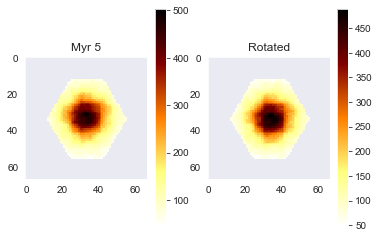

<Figure size 432x288 with 0 Axes>

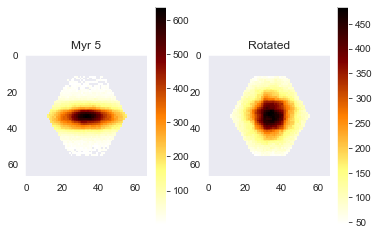

<Figure size 432x288 with 0 Axes>

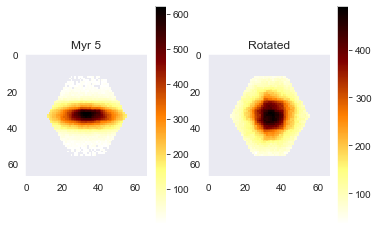

<Figure size 432x288 with 0 Axes>

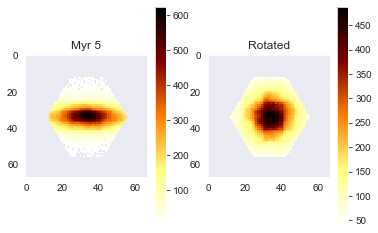

<Figure size 432x288 with 0 Axes>

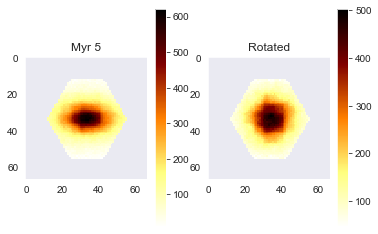

<Figure size 432x288 with 0 Axes>

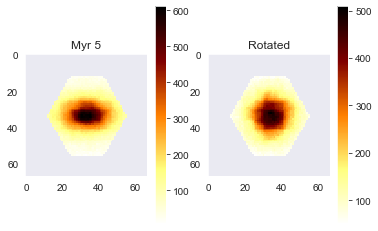

<Figure size 432x288 with 0 Axes>

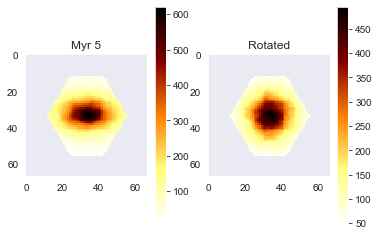

In [151]:
# This code will compare images from the files to see if the rotation
# is working for the isolated galaxies.
print(os.getcwd())
view_list=[0,1,2,3,4,5,6]
myr_list=[5]

for j in range(len(view_list)):
    kin_cube=0
    kin_cube_2=0
    view = view_list[j]
    myr = myr_list[0]
    
    try:
        kin_cube=pyfits.open('kinematic_maps/stellar_kinematics_SCATTER_emline_fg3_m12_iso0.5_'+str(myr)+'_'+str(view)+'.fits')
    except:
        continue
    vel_ogg = ma.masked_where(kin_cube[1].data==0, kin_cube[1].data)
    vel_e = ma.masked_where(kin_cube[2].data==0, kin_cube[2].data)
    sig_ogg = ma.masked_where(kin_cube[3].data==0, kin_cube[3].data)
    sig_ogg_e = ma.masked_where(kin_cube[4].data==0, kin_cube[4].data)
    r_band = kin_cube[5].data
    r_band = ma.masked_where(r_band>1e10, r_band)
    
    plt.clf()
    fig=plt.figure()
    ax0 = fig.add_subplot(121)
    im0 = ax0.imshow(r_band, cmap='afmhot_r')
    plt.title('Myr '+str(myr))
    plt.colorbar(im0)
    try:
        kin_cube_2=pyfits.open('kinematic_maps/stellar_kinematics_SCATTER_emline_fg3_m12_iso0.5_rotated_'+str(myr)+'_'+str(view)+'.fits')
    except:
        print('DNE')
        continue
    vel_test = ma.masked_where(kin_cube_2[1].data==0, kin_cube_2[1].data)
    
    r_band = kin_cube_2[5].data
    r_band = ma.masked_where(r_band>1e10, r_band)
    
    ax1 = fig.add_subplot(122)
    im1 = ax1.imshow(r_band, cmap='afmhot_r')#, norm=matplotlib.colors.LogNorm()
    ax1.set_title('Rotated')
    plt.colorbar(im1)
    plt.show()
    


In [3]:
# Look at the two broadband files separately.
rotated_im = pyfits.open('images/isolated_galaxies/m0.333_fg0.1/rot_45/broadband_005.fits')
im_og = pyfits.open('images/isolated_galaxies/m0.333_fg0.1/broadband_005.fits')

In [4]:
viewpt = 1
print(rotated_im['CAMERA'+str(viewpt)+'-PARAMETERS'].header)
print('~~~~~~~')
print(im_og['CAMERA'+str(viewpt)+'-PARAMETERS'].header)

XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                  300 / length of data axis 1                          NAXIS2  =                  300 / length of data axis 2                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     EXTNAME = 'CAMERA1-PARAMETERS'                                                  HDUVERS =                    1                                                  COMMENT This HDU contains the camera parameters. The image contains the solid anCOMMENT gle subtended by the individual pixels.                                 HISTORY This HDU was created by Sunrise (class camera_base) version , on Sat OctHISTORY   5 14:09:20 2019 by user rebecc

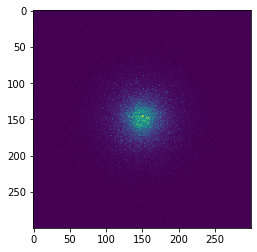

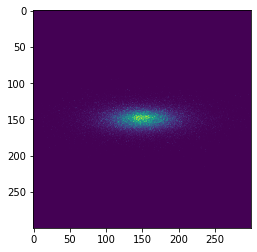

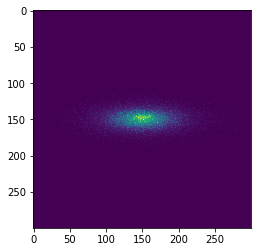

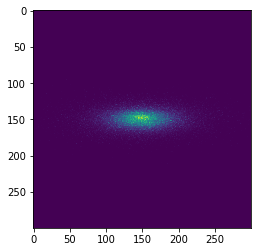

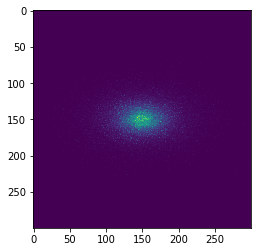

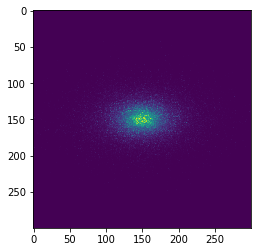

In [9]:
for j in range(6):
    plt.clf()
    plt.imshow(im_og['CAMERA'+str(j)+'-BROADBAND'].data[2])
    plt.show()